## Dependencies

In [1]:
!pip install kmodes

In [2]:
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA, IndexToString
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
from kmodes.kprototypes import KPrototypes
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, PCA as SparkPCA
from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

## Read the data and prepare it for the analysis and visualization

In [3]:
spark = SparkSession.builder \
    .appName("SpotifyClustering") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

In [4]:
path = "hdfs://namenode:9000/spotify/clean_data"

# 1) Read with header, no schema (but robust CSV options)
df0 = (spark.read
       .option("header", True)
       .option("multiLine", True)
       .option("quote", '"')
       .option("escape", '"')
       .option("mode", "PERMISSIVE")
       .csv(path))

print(df0.columns)      
#df0.show(3, truncate=False)

# 2) Cast columns by NAME (not by position)
cast_to = {
    "popularity": "int",
    "duration_ms": "int",
    "explicit": "boolean",   
    "danceability": "double",
    "energy": "double",
    "key": "int",
    "loudness": "double",
    "mode": "int",
    "speechiness": "double",
    "acousticness": "double",
    "instrumentalness": "double",
    "liveness": "double",
    "valence": "double",
    "tempo": "double",
    "time_signature": "int",
    "track_genre": "string",
}

df = df0.select(*[
    F.col(c).cast(cast_to[c]).alias(c) if c in cast_to else F.col(c)
    for c in df0.columns
])
df = df.na.drop(subset=df.columns)

['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'explicit_int']


We initially wanted to use Kmeans to cluster our data. However since we have both categorical and numeric data, using kmeans would mean that we have to drop a lot of information. Instead, we decided to use kprototype to be able to keep both datatypes. However, Kprototype is not implemented in spark so we nee to use pandas. 

In [5]:
# We want to cluster the music by their characteristic so we will remove some columns
print(df.columns)
df_2 = df.drop(df.track_id, df.album_name, df.track_name, df.artists, df.explicit)
df_2.show()
print(df_2.columns)

['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'explicit_int']
+----------+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-------------+------------+
|popularity|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|  track_genre|explicit_int|
+----------+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-------------+------------+
|        44|     160725|        0.91| 0.374|  8|  -9.844|   0|      0.199|      0.0757|         0.00301|   0.154|  0.432|104.042|             4|       german|           1|
|        14|      56200|       0.2

Let's look at the number of unique genre

In [6]:
num_unique = df_2.select("track_genre").distinct().count()
print("There is", num_unique,"genres.")

There is 113 genres.


In [7]:
# We separate the continuous and discrete columns
cat_columns = ["track_genre", "explicit_int", "time_signature", "mode", "key"]
num_columns = df_2.columns
for name in cat_columns :
    num_columns.remove(name)

# We are going to normalize the columns which are continuous
for c in num_columns:
    stats = df_2.select(F.mean(c).alias("mean"), F.stddev(c).alias("std")).first()
    mean_val = stats["mean"]
    std_val = stats["std"]
    df_2 = df_2.withColumn(c, (F.col(c) - F.lit(mean_val)) / F.lit(std_val))

# We need to encode the columns that are categorical
# key, mode and time_signature are already encoded
# We need to convert explicit_int to int because it is currently a string
df_2 = df_2.withColumn("explicit_int", df_2["explicit_int"].cast(IntegerType()))

#We encode track_genre
indexer = StringIndexer(inputCol="track_genre", outputCol="genre_index")
df_2 = indexer.fit(df_2).transform(df_2)
df_indexed = df_2.drop("track_genre")
cat_columns.remove("track_genre")
cat_columns.append("genre_index")

df_indexed.dtypes

[('popularity', 'double'),
 ('duration_ms', 'double'),
 ('danceability', 'double'),
 ('energy', 'double'),
 ('key', 'int'),
 ('loudness', 'double'),
 ('mode', 'int'),
 ('speechiness', 'double'),
 ('acousticness', 'double'),
 ('instrumentalness', 'double'),
 ('liveness', 'double'),
 ('valence', 'double'),
 ('tempo', 'double'),
 ('time_signature', 'int'),
 ('explicit_int', 'int'),
 ('genre_index', 'double')]

Let's proceed with the clustering

## K-prototype analysis

In [8]:
data = df_indexed.toPandas()

costs = []
K = range(2, 11)  
cat_cols = [data.columns.get_loc(c) for c in cat_columns]

In [9]:
for k in K:
    print("k =",k)
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=1, random_state=42, max_iter=20, n_init=1)
    clusters = kproto.fit_predict(data, categorical=cat_cols)
    costs.append(kproto.cost_)

k = 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 20298, ncost: 938539.7284151816
Run: 1, iteration: 2/20, moves: 12736, ncost: 917310.1783634479
Run: 1, iteration: 3/20, moves: 5311, ncost: 913301.3812879078
Run: 1, iteration: 4/20, moves: 2140, ncost: 912574.1113116443
Run: 1, iteration: 5/20, moves: 952, ncost: 912408.7229138175
Run: 1, iteration: 6/20, moves: 423, ncost: 912377.9310701966
Run: 1, iteration: 7/20, moves: 155, ncost: 912373.7416505179
Run: 1, iteration: 8/20, moves: 60, ncost: 912373.0630868135
Run: 1, iteration: 9/20, moves: 17, ncost: 912373.0041366463
Run: 1, iteration: 10/20, moves: 0, ncost: 912373.0041366463
k = 3
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 30010, ncost: 849730.

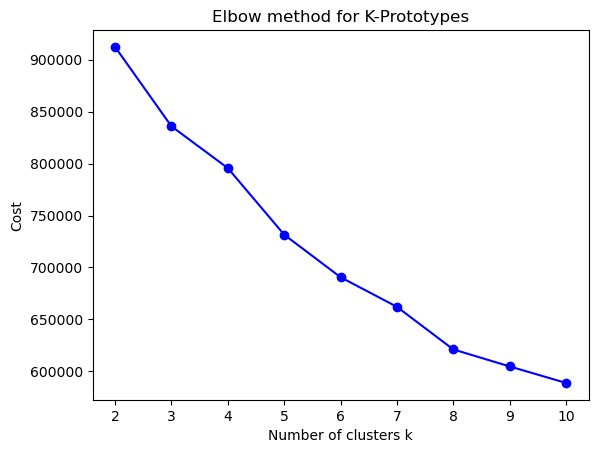

In [10]:
# Plot the elbow
import matplotlib.pyplot as plt
plt.plot(K, costs, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost')
plt.title('Elbow method for K-Prototypes')
plt.show()

We can pick k=5 since there is quite a steep decrease between 4 and 5. But it's quite difficult to use the elbow rule with this plot. 

In [11]:
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=1, random_state=42, max_iter=50, n_init=2)
clusters = kproto.fit_predict(data, categorical=cat_cols)
data["clusters"] = clusters

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/50, moves: 36881, ncost: 771820.0239324854
Run: 1, iteration: 2/50, moves: 17211, ncost: 755190.439025521
Run: 1, iteration: 3/50, moves: 11666, ncost: 743545.2596755687
Run: 1, iteration: 4/50, moves: 8653, ncost: 735328.2252774177
Run: 1, iteration: 5/50, moves: 4925, ncost: 732088.1522252393
Run: 1, iteration: 6/50, moves: 1883, ncost: 731632.7129733264
Run: 1, iteration: 7/50, moves: 574, ncost: 731593.5266321971
Run: 1, iteration: 8/50, moves: 230, ncost: 731588.0730514065
Run: 1, iteration: 9/50, moves: 113, ncost: 731587.0105074175
Run: 1, iteration: 10/50, moves: 56, ncost: 731586.6255636935
Run: 1, iteration: 11/50, moves: 51, ncost: 731586.3225976777
Run: 1, iteration: 12/50, moves: 36, ncost: 731586.1919943154
Run: 1, iteration: 13/50, moves: 28, ncost: 731586.0787394053
Run: 1, iteration: 14/50, move

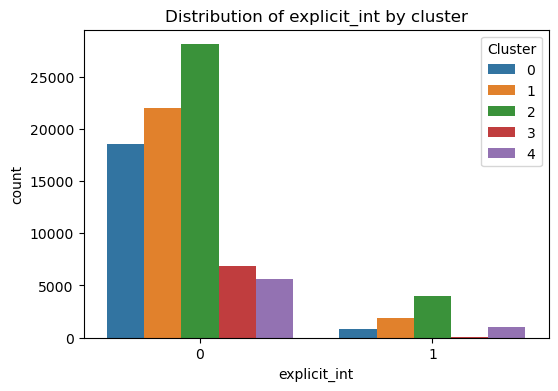

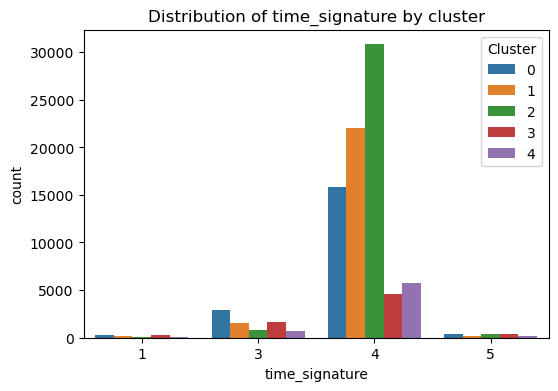

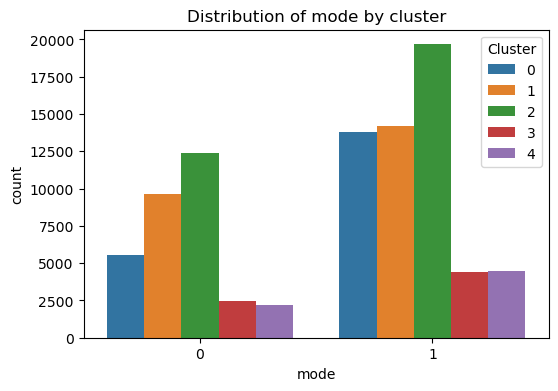

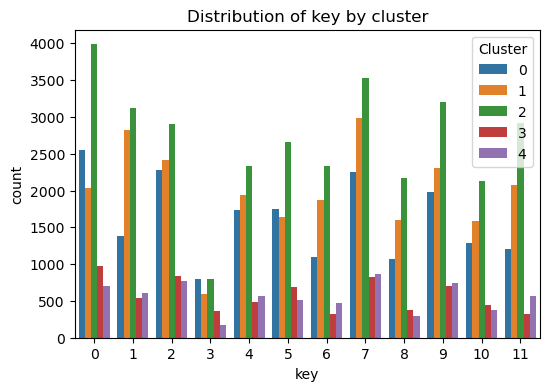

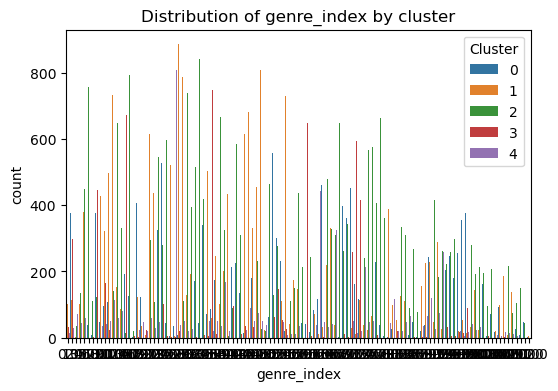

In [12]:
for col in cat_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x=col, hue='clusters', palette='tab10')
    plt.title(f'Distribution of {col} by cluster')
    plt.legend(title='Cluster')
    plt.show()

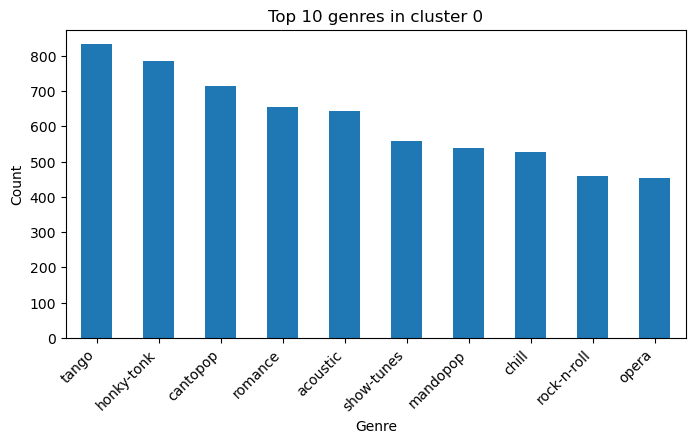

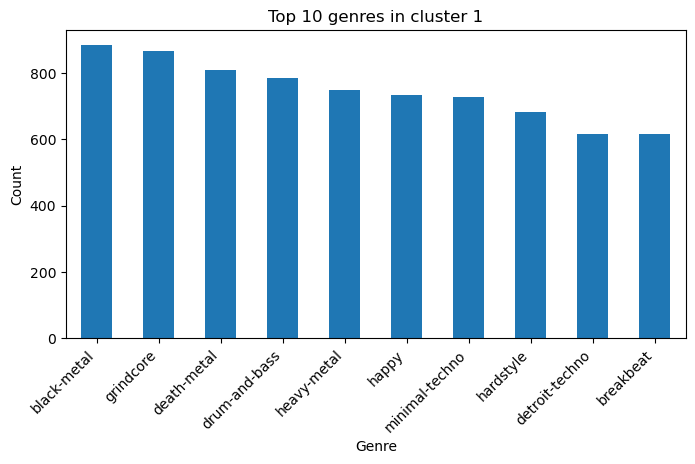

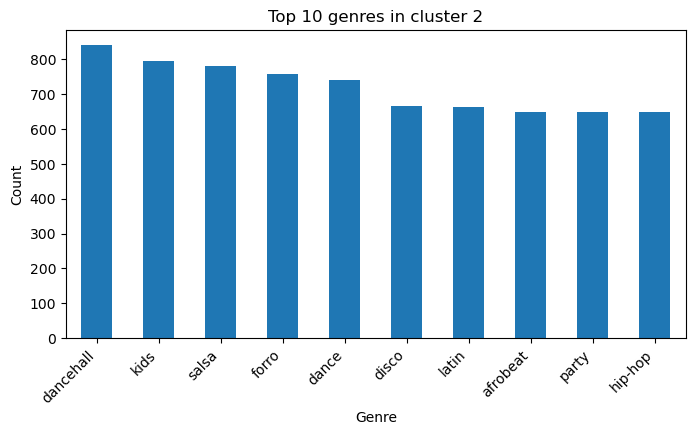

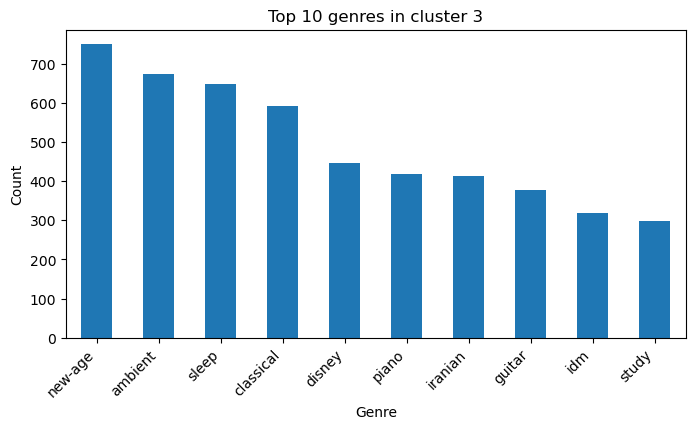

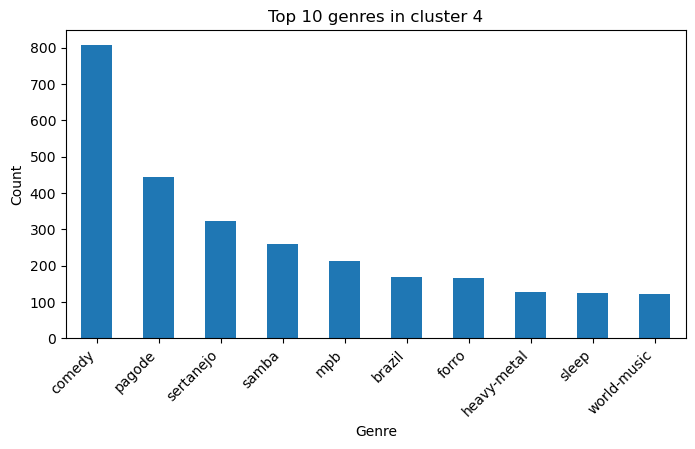

In [13]:
mapping = dict(df_2.select("genre_index", "track_genre").distinct().collect())
data["track_genre"] = data["genre_index"].map(mapping)
top_n = 10  # number of top genres to show

for cluster_id in sorted(data['clusters'].unique()):
    top_genres = (
        data[data['clusters'] == cluster_id]['track_genre']
        .value_counts()
        .head(top_n)
    )

    plt.figure(figsize=(8, 4))
    top_genres.plot(kind='bar')
    plt.title(f"Top {top_n} genres in cluster {cluster_id}")
    plt.ylabel("Count")
    plt.xlabel("Genre")
    plt.xticks(rotation=45, ha='right')
    plt.show()

   popularity  duration_ms  danceability    energy  loudness  speechiness  \
0    0.030093    -0.188010     -0.129520 -0.982381 -0.275786    -0.347969   
1   -0.076482     0.510498     -0.430522  0.658375 -0.088612     0.376699   
2    0.089717    -0.230924      0.689650  0.387863  0.061023    -0.401236   
3   -0.248240    -0.183236     -1.153503 -1.760618 -0.303991     1.877988   
4    0.009761     0.018377     -0.215025  0.441580  1.137151    -0.336447   

   acousticness  instrumentalness  liveness  valence  tempo  
0     -0.281469         -0.241715 -0.290835      0.0    4.0  
1     -0.127227         -0.608522  0.441549      0.0    4.0  
2     -0.235552          0.811873 -0.021141      0.0    4.0  
3     -0.313258         -1.076808 -0.562243      0.0    4.0  
4      2.727731          0.081273 -0.055752      0.0    4.0  


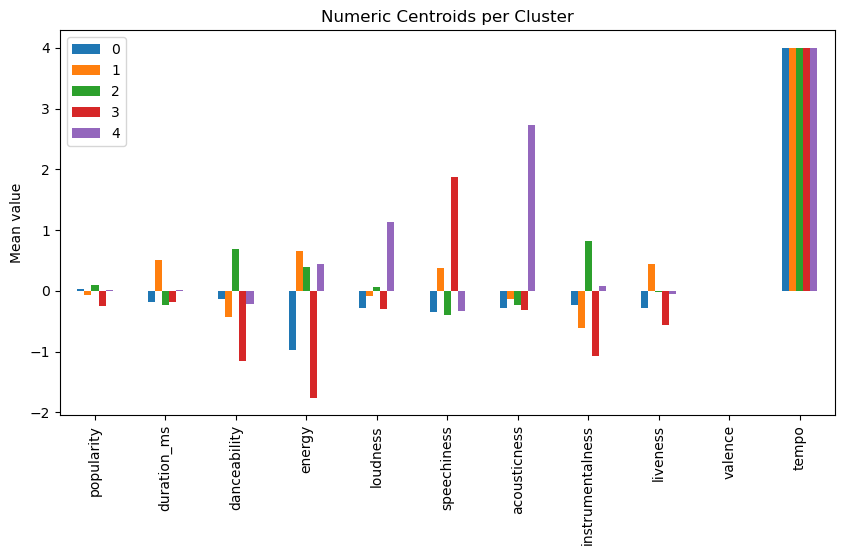

In [14]:
num_cols = [i for i in range(0,16)]
for n in cat_cols :
    num_cols.remove(n)
    

centroids = pd.DataFrame(kproto.cluster_centroids_[:,num_cols], columns=data.columns[num_cols])
print(centroids)

centroids.T.plot(kind='bar', figsize=(10, 5))
plt.title('Numeric Centroids per Cluster')
plt.ylabel('Mean value')
plt.show()


Silhouette Score (only for numerical features): 0.1381
Range: [-1, 1], higher is better


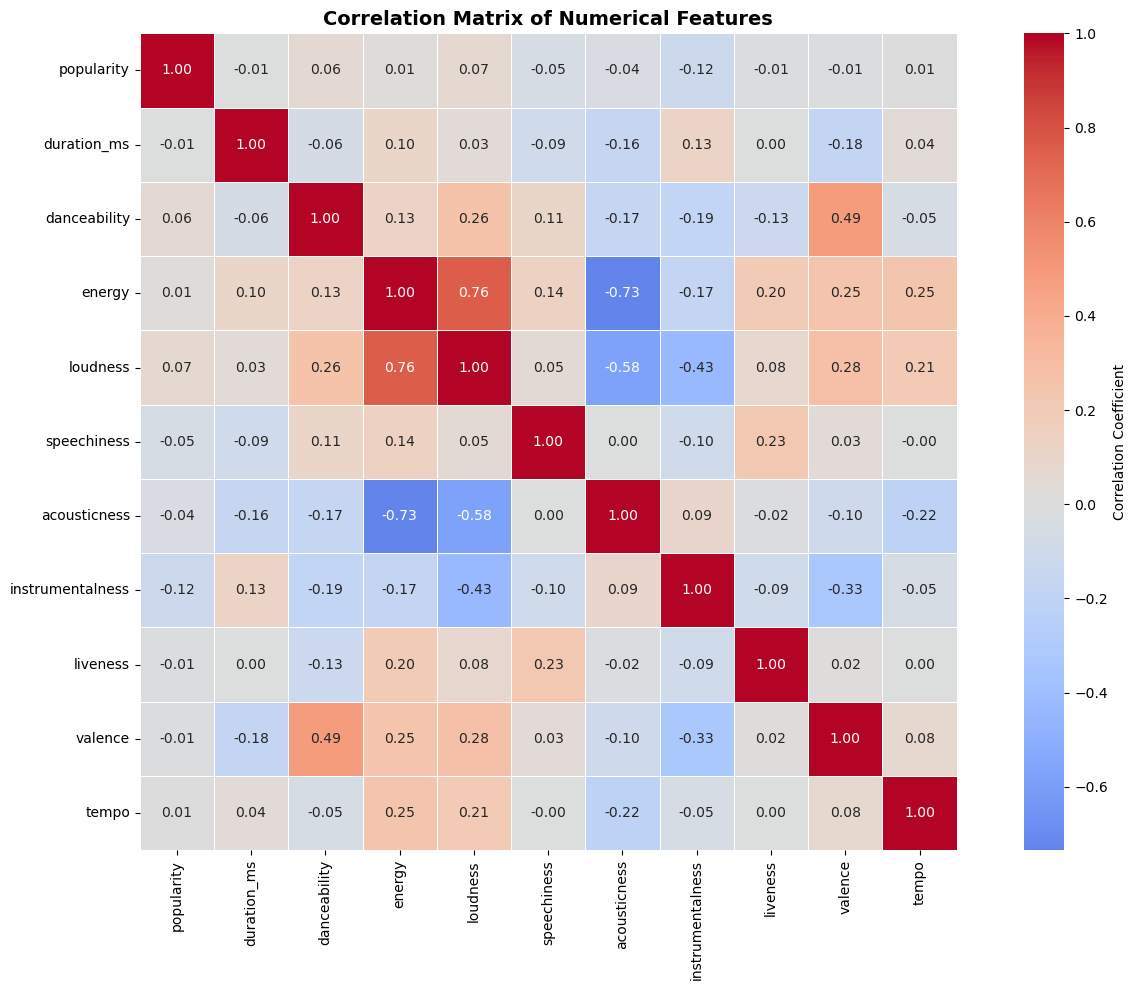

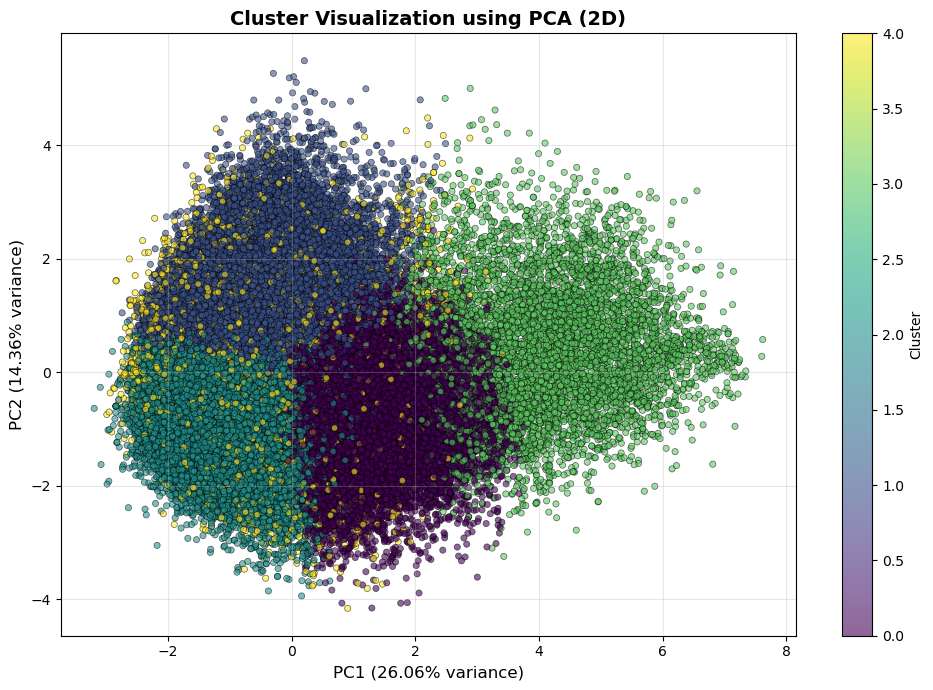

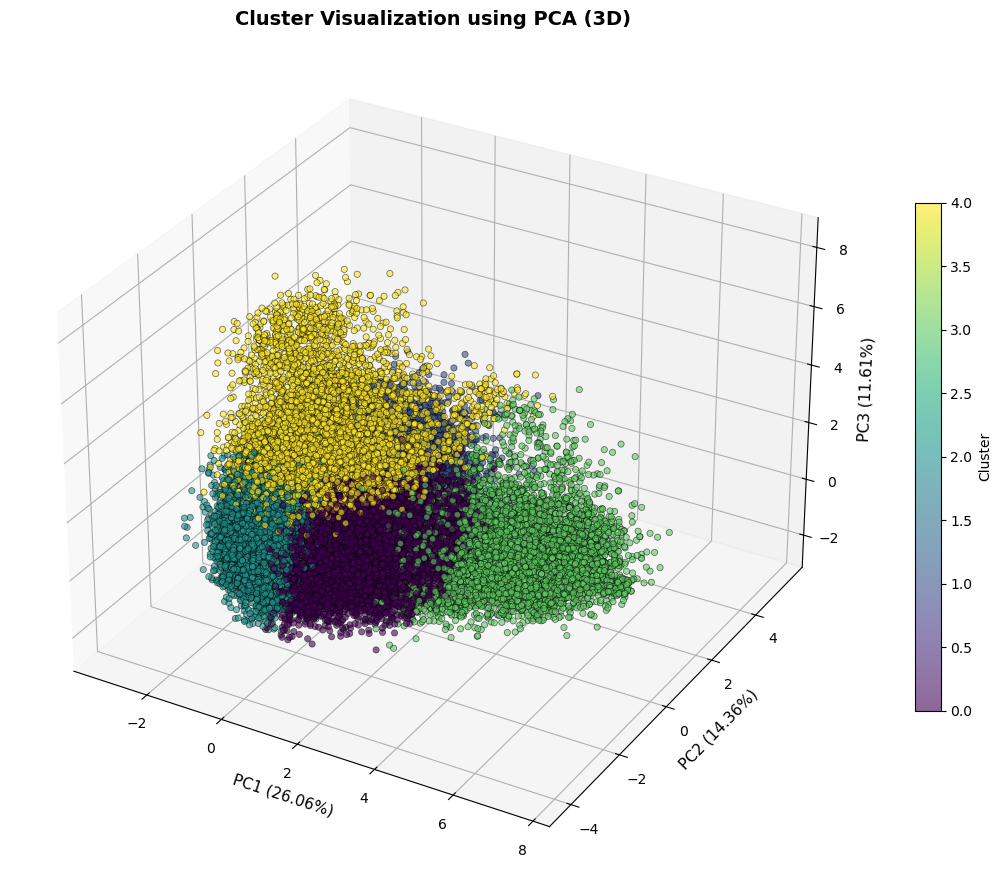


PCA Explained Variance:
  PC1: 26.06%
  PC2: 14.36%
  PC3: 11.61%
  Total: 52.02%

Cluster 0:
Size: 19382 tracks (21.8%)
Most common genre: tango
Key characteristics (by mean):
  danceability: -0.130
  energy: -0.982
  valence: -0.242
  acousticness: 1.029

Cluster 1:
Size: 23871 tracks (26.9%)
Most common genre: black-metal
Key characteristics (by mean):
  danceability: -0.431
  energy: 0.658
  valence: -0.609
  acousticness: -0.782

Cluster 2:
Size: 32084 tracks (36.1%)
Most common genre: dancehall
Key characteristics (by mean):
  danceability: 0.690
  energy: 0.388
  valence: 0.812
  acousticness: -0.389

Cluster 3:
Size: 6853 tracks (7.7%)
Most common genre: new-age
Key characteristics (by mean):
  danceability: -1.154
  energy: -1.761
  valence: -1.077
  acousticness: 1.533

Cluster 4:
Size: 6671 tracks (7.5%)
Most common genre: comedy
Key characteristics (by mean):
  danceability: -0.215
  energy: 0.442
  valence: 0.081
  acousticness: 0.104


In [15]:
cluster_sizes = data['clusters'].value_counts().sort_index()
# Silhouette Score (only for numerical features)
numerical_data = data.iloc[:, num_cols].values
clusters_array = data['clusters'].values

silhouette = silhouette_score(numerical_data, clusters_array)
print(f"\nSilhouette Score (only for numerical features): {silhouette:.4f}")
print("Range: [-1, 1], higher is better")

# Correlation matrix for numerical features
numerical_features = data.iloc[:, num_cols]
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# PCA visualization - for numerical features
pca = PCA(n_components=3, random_state=42)
pca_result = pca.fit_transform(numerical_data)

# 2D Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                     c=clusters_array, cmap='viridis', 
                     alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('Cluster Visualization using PCA (2D)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3D Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                     c=clusters_array, cmap='viridis', 
                     alpha=0.6, s=20, edgecolors='k', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})', fontsize=11)
ax.set_title('Cluster Visualization using PCA (3D)', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='Cluster', shrink=0.6)
plt.tight_layout()
plt.show()

print(f"\nPCA Explained Variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  PC3: {pca.explained_variance_ratio_[2]:.2%}")
print(f"  Total: {sum(pca.explained_variance_ratio_):.2%}")


# Summary 

for cluster_id in sorted(data['clusters'].unique()):
    print(f"\nCluster {cluster_id}:")
    print(f"Size: {cluster_sizes[cluster_id]} tracks ({cluster_sizes[cluster_id]/len(data)*100:.1f}%)")
    
    cluster_data = data[data['clusters'] == cluster_id]
    
    top_genre = cluster_data['track_genre'].mode()[0]
    print(f"Most common genre: {top_genre}")
    
    print("Key characteristics (by mean):")
    for feat in ['danceability', 'energy', 'valence', 'acousticness']:
        if feat in cluster_data.columns:
            print(f"  {feat}: {cluster_data[feat].mean():.3f}")



## K-means analysis

If we still want to do the Kmeans, we can do so by removing the categorical features.

In [16]:
# We need to convert the columns of the df to feature vectors
assembler = VectorAssembler(inputCols=num_columns, outputCol="features")
df_features = assembler.transform(df_indexed)

In [17]:
# We use the elbow method to chose the number of cluster
inertia = []
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='features', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')
list_k = [k for k in range(2,11)]
for k in list_k :
    kmeans = KMeans(k = k, seed = 42)
    model = kmeans.fit(df_features)
    inertia.append(model.summary.trainingCost)
    df_temp = model.transform(df_features)
    score=evaluator.evaluate(df_temp)
    silhouette_score.append(score)

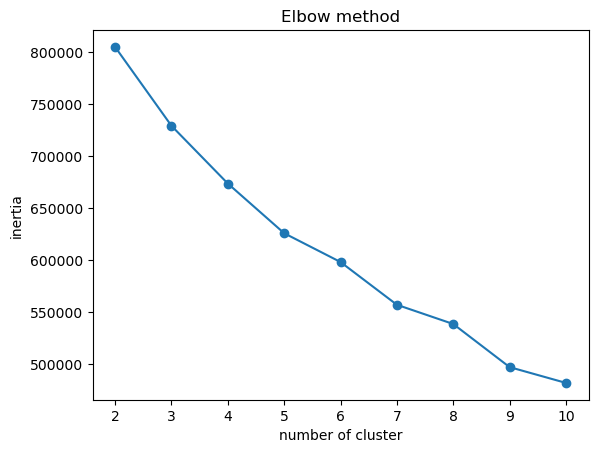

In [18]:
plt.plot(list_k, inertia,"o-")
plt.xlabel("number of cluster")
plt.ylabel("inertia")
plt.title("Elbow method")
plt.show()

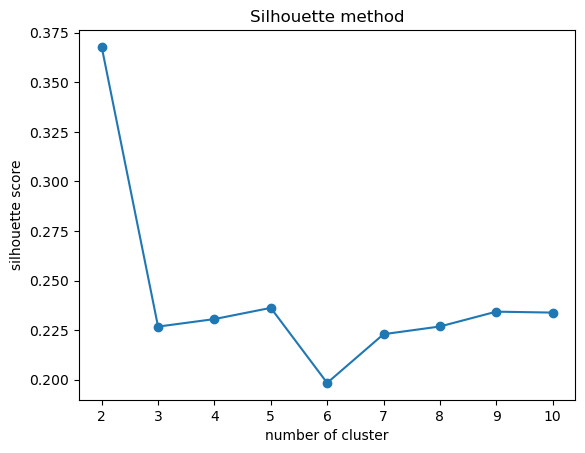

In [19]:
plt.plot(list_k, silhouette_score,"o-")
plt.xlabel("number of cluster")
plt.ylabel("silhouette score")
plt.title("Silhouette method")
plt.show()

We choose a number of cluster of 5 because for the elbow plot, the decrease between k=5 and k=6 is not as steep. Furthermore, for the silhouette plot, the silhouette score goes up for 5 and then goes down again so it's a local maximum. We could also tried k=9 for the same reasons. 

In [20]:
kmeans = KMeans(k = 5, seed = 42)
model = kmeans.fit(df_features)
df_labeled = model.transform(df_features)

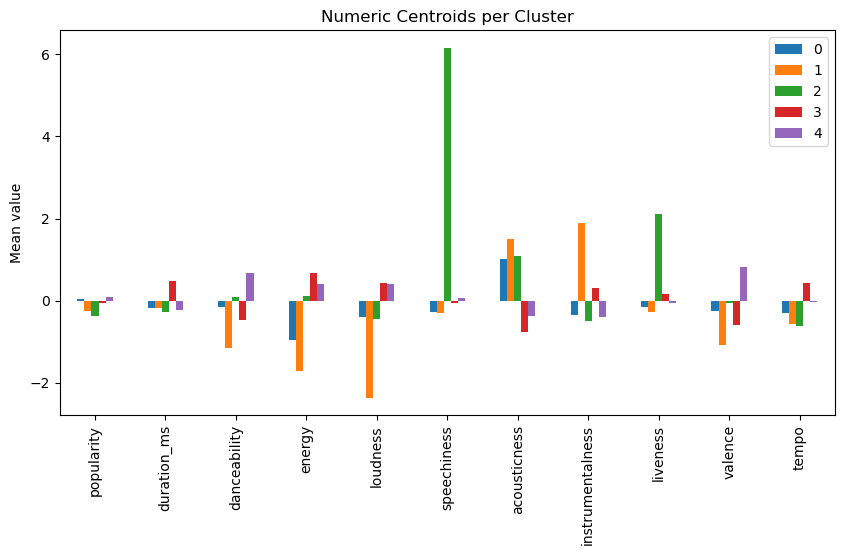

In [21]:

centroids = model.clusterCenters()
df_centroids = pd.DataFrame(centroids, columns=num_columns)

df_centroids.T.plot(kind='bar', figsize=(10, 5))
plt.title('Numeric Centroids per Cluster')
plt.ylabel('Mean value')
plt.show()

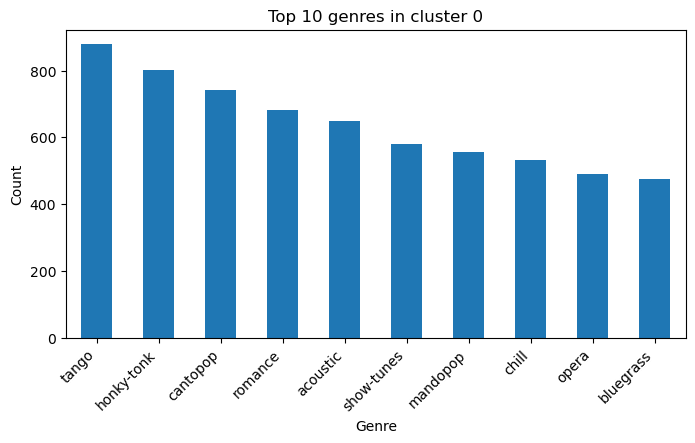

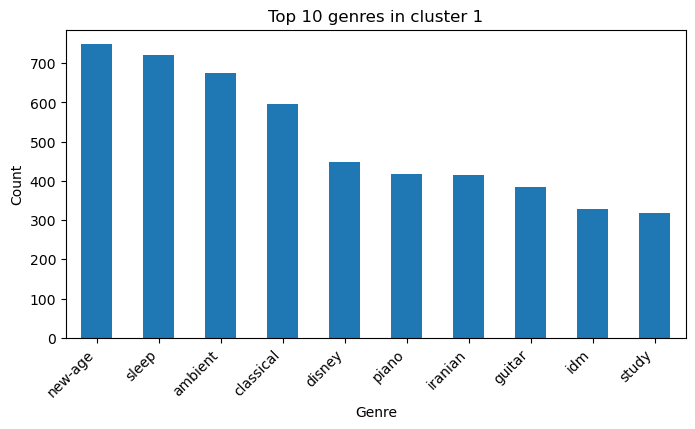

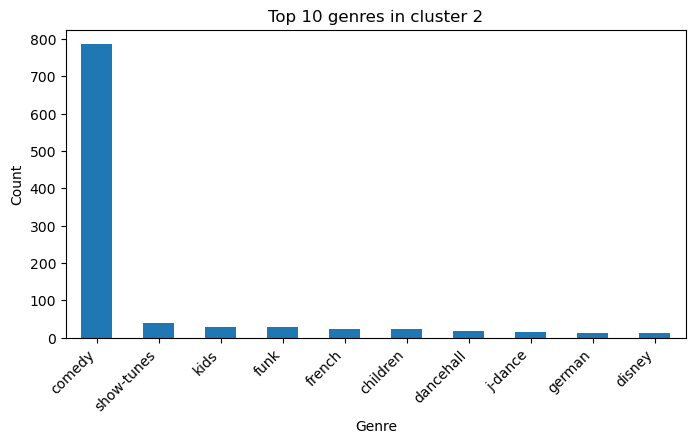

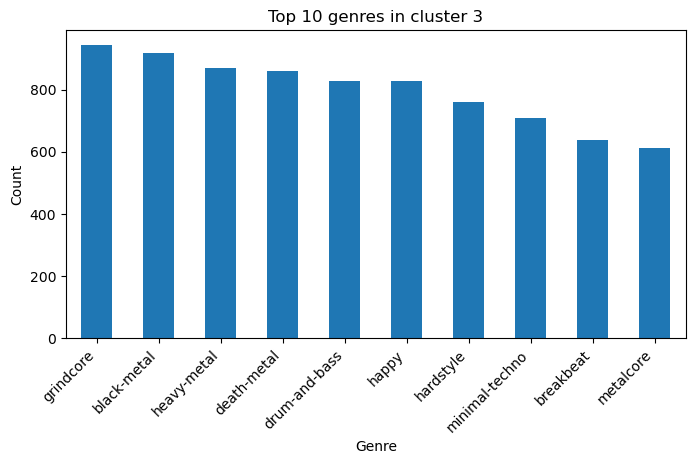

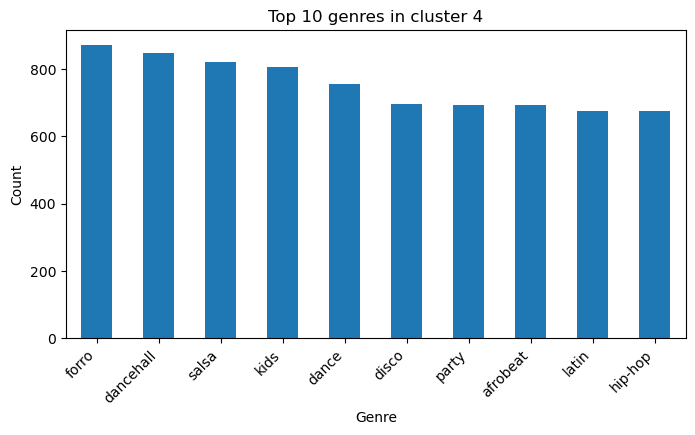

In [22]:
mapping = dict(df_2.select("genre_index", "track_genre").distinct().collect())
top_n = 10  # number of top genres to show
data_bis = df_labeled.toPandas()
data_bis["track_genre"] = data_bis["genre_index"].map(mapping)

for cluster_id in sorted(data_bis['prediction'].unique()):
    top_genres = (
        data_bis[data_bis['prediction'] == cluster_id]['track_genre']
        .value_counts()
        .head(top_n)
    )

    plt.figure(figsize=(8, 4))
    top_genres.plot(kind='bar')
    plt.title(f"Top {top_n} genres in cluster {cluster_id}")
    plt.ylabel("Count")
    plt.xlabel("Genre")
    plt.xticks(rotation=45, ha='right')
    plt.show()


Silhouette Score (only for numerical features): 0.2362


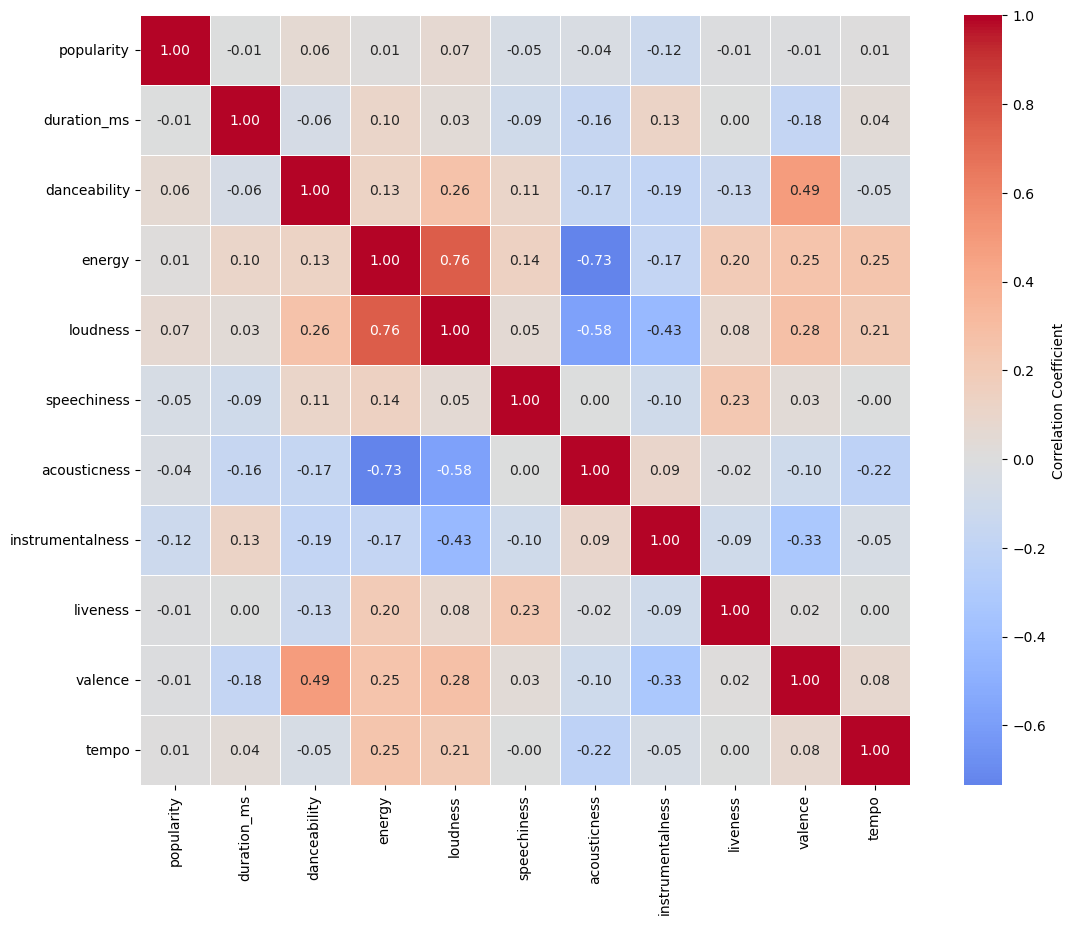

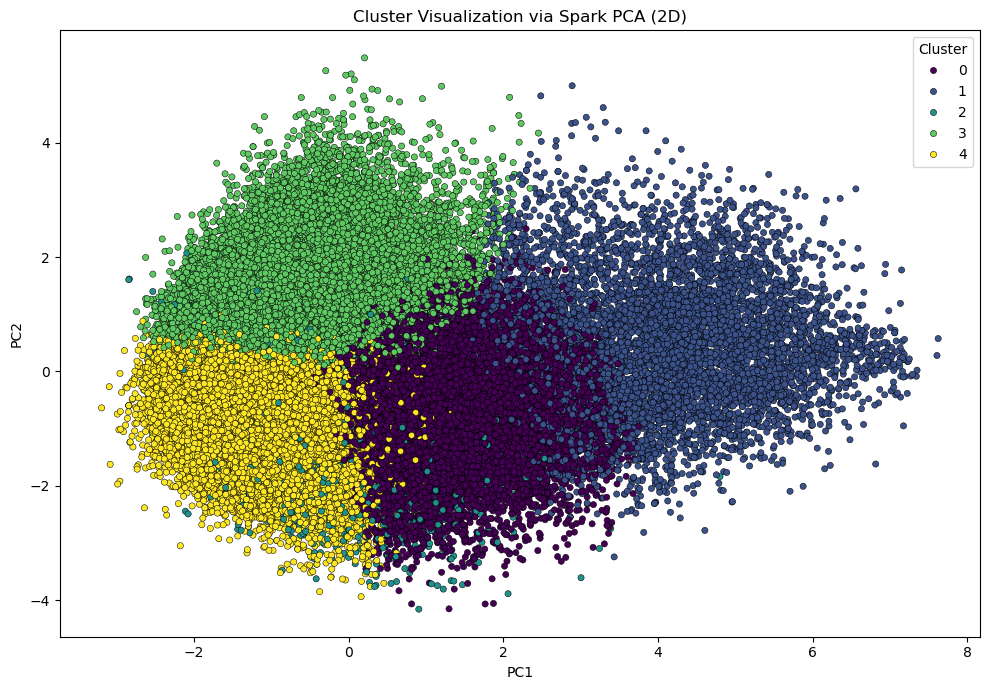

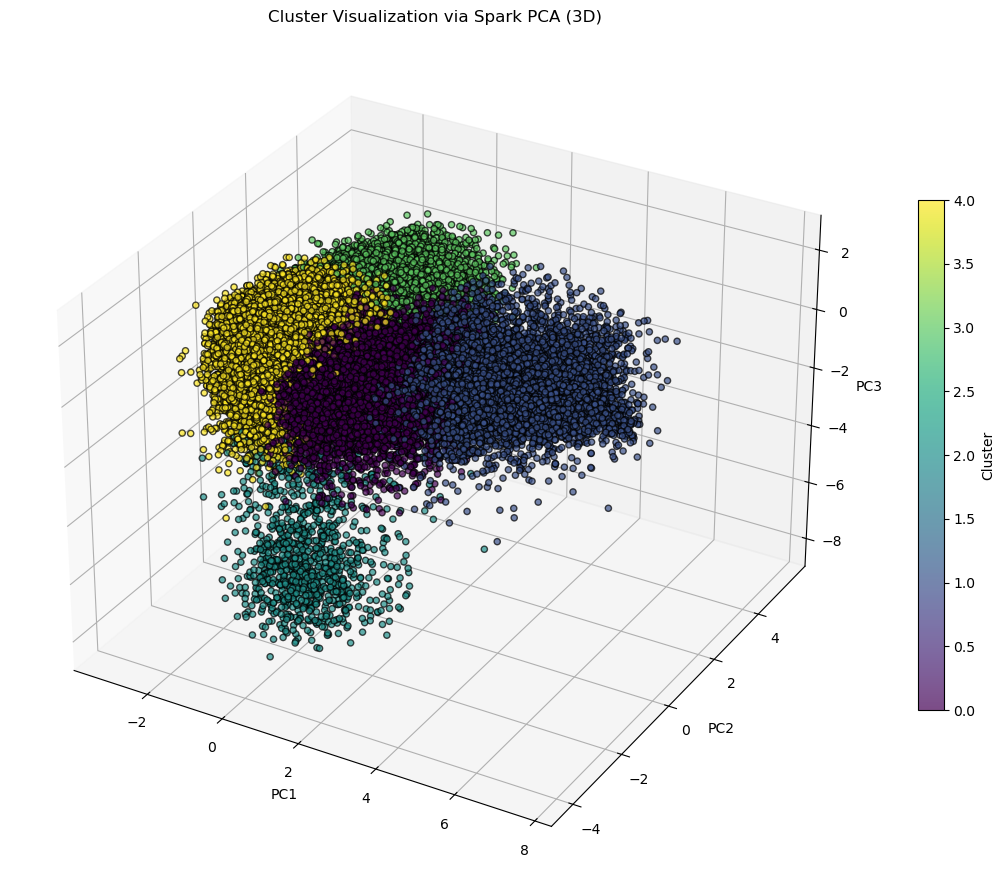


PCA Explained Variance:
  PC1: 26.06%
  PC2: 14.36%
  PC3: 11.61%
  Total: 52.02%
CLUSTER SUMMARY STATISTICS:

Cluster 0:
Size: 20338 tracks (22.9%)
Key characteristics (by mean):
  danceability: -0.144
  energy: -0.960
  valence: -0.238
  acousticness: 1.016

Cluster 1:
Size: 7034 tracks (7.9%)
Key characteristics (by mean):
  danceability: -1.147
  energy: -1.716
  valence: -1.079
  acousticness: 1.507

Cluster 2:
Size: 1193 tracks (1.3%)
Key characteristics (by mean):
  danceability: 0.080
  energy: 0.130
  valence: -0.065
  acousticness: 1.096

Cluster 3:
Size: 25983 tracks (29.2%)
Key characteristics (by mean):
  danceability: -0.470
  energy: 0.682
  valence: -0.598
  acousticness: -0.767

Cluster 4:
Size: 34313 tracks (38.6%)
Key characteristics (by mean):
  danceability: 0.674
  energy: 0.400
  valence: 0.818
  acousticness: -0.369


In [23]:
# Silhouette Score (only for numerical features)
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='features',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(df_labeled)
print(f"\nSilhouette Score (only for numerical features): {silhouette:.4f}")

# Correlation matrix for numerical features
corr_matrix = Correlation.corr(df_labeled, 'features', 'pearson').collect()[0][0].toArray()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'},
            xticklabels=num_columns, yticklabels=num_columns)


# PCA visualization - for numerical features
pca = SparkPCA(k=3, inputCol="features", outputCol="pca_features")
model_pca = pca.fit(df_features)
df_pca = model_pca.transform(df_labeled)
df_pca = df_pca.withColumn("pca_array", vector_to_array("pca_features"))
df_vis = df_pca.withColumn("PC1", F.col("pca_array")[0]) \
               .withColumn("PC2", F.col("pca_array")[1]) \
               .withColumn("PC3", F.col("pca_array")[2]) \
               .select("PC1", "PC2", "PC3", "prediction")

pdf_vis = df_vis.toPandas()
pdf_vis = df_vis.toPandas()

# 2D
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pdf_vis, x="PC1", y="PC2", hue="prediction", palette='viridis', s=20, edgecolor='k')
plt.title("Cluster Visualization via Spark PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pdf_vis["PC1"], pdf_vis["PC2"], pdf_vis["PC3"],
                     c=pdf_vis["prediction"], cmap='viridis', s=20, alpha=0.7, edgecolors='k')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Cluster Visualization via Spark PCA (3D)")
plt.colorbar(scatter, ax=ax, label='Cluster', shrink=0.6)
plt.tight_layout()
plt.show()

print(f"\nPCA Explained Variance:")
explained_var = model_pca.explainedVariance
print(f"  PC1: {explained_var[0]:.2%}")
print(f"  PC2: {explained_var[1]:.2%}")
print(f"  PC3: {explained_var[2]:.2%}")
print(f"  Total: {sum(explained_var):.2%}")

# Summary
data_bis = df_labeled.toPandas()
cluster_sizes = data_bis['prediction'].value_counts().sort_index()
print("CLUSTER SUMMARY STATISTICS:")
for cluster_id in sorted(data_bis['prediction'].unique()):
    print(f"\nCluster {cluster_id}:")
    print(f"Size: {cluster_sizes[cluster_id]} tracks ({cluster_sizes[cluster_id]/len(data_bis)*100:.1f}%)")
    cluster_data = data_bis[data_bis['prediction'] == cluster_id]
    if 'track_genre' in cluster_data.columns:
        top_genre = cluster_data['track_genre'].mode()[0]
        print(f"Most common genre: {top_genre}")
    print("Key characteristics (by mean):")
    for feat in ['danceability', 'energy', 'valence', 'acousticness']:
        if feat in cluster_data.columns:
            print(f"  {feat}: {cluster_data[feat].mean():.3f}")